In [83]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import missingno as msno
import plotly.express as px
import math

In [84]:
#Load data
df = pd.read_csv('data/df_incidents_poverty_house_data_preparation_final.csv')

In [85]:
#View columns
df.columns

Index(['state', 'city_or_county', 'latitude', 'longitude',
       'avg_age_participants', 'datetime', 'males_ratio',
       'state_congressional_district', 'povertyPercentage', 'killed_ratio',
       'injured_ratio', 'unharmed_ratio', 'candidate_winning_ratio',
       'males_in_month_ratio', 'killed_in_month_ratio',
       'injured_in_month_ratio', 'unharmed_in_month_ratio'],
      dtype='object')

In [86]:
#Describe data
df.describe()

,latitude,longitude,avg_age_participants,males_ratio,povertyPercentage,killed_ratio,injured_ratio,unharmed_ratio,candidate_winning_ratio,males_in_month_ratio,killed_in_month_ratio,injured_in_month_ratio,unharmed_in_month_ratio
count,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000,92561.000000
mean,37.571528,-89.970654,30.901254,0.750367,12.417237,0.172228,0.314412,0.045845,0.696398,0.024326,0.022091,0.021347,0.008808
std,4.829544,13.116223,10.983214,0.409529,2.721521,0.339893,0.429770,0.145918,0.119988,0.026423,0.051190,0.042048,0.031795
min,24.551600,-134.782000,4.000000,0.000000,7.100000,0.000000,0.000000,0.000000,0.412840,0.000000,0.000000,0.000000,0.000000
25%,33.775200,-93.260800,22.000000,0.500000,10.700000,0.000000,0.000000,0.000000,0.609135,0.004098,0.000000,0.000000,0.000000
50%,38.813800,-87.630000,28.000000,1.000000,12.200000,0.000000,0.000000,0.000000,0.678367,0.016667,0.000000,0.000000,0.000000
75%,41.640400,-81.792400,37.000000,1.000000,13.700000,0.000000,1.000000,0.000000,0.766960,0.035714,0.000000,0.022222,0.000000
max,58.473200,-67.299600,67.000000,1.000000,20.600000,1.000000,1.000000,0.666667,1.000000,0.157895,0.250000,0.230769,0.200000


In [87]:
# Convert 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

In [88]:
#filter incidents from 2014 to 2017
filtered_df = df[df['datetime'].dt.year.isin([2014, 2015, 2016, 2017])].copy()

In [89]:
filtered_df.head()

,state,city_or_county,latitude,longitude,avg_age_participants,datetime,males_ratio,state_congressional_district,povertyPercentage,killed_ratio,injured_ratio,unharmed_ratio,candidate_winning_ratio,males_in_month_ratio,killed_in_month_ratio,injured_in_month_ratio,unharmed_in_month_ratio
0,Indiana,Indianapolis,39.8322,-86.2492,19.0,2015-05-02,1.0,indiana_7,12.3,0.000000,1.000000,0.0,0.547323,0.009434,0.000000,0.032258,0.0
1,Missouri,Kansas City (Raytown),38.9647,-94.4654,29.0,2016-12-21,1.0,missouri_5,11.9,0.000000,0.000000,0.0,0.588294,0.014925,0.000000,0.000000,0.0
3,Illinois,Chicago,41.8895,-87.7507,36.0,2016-07-08,1.0,illinois_7,10.9,0.333333,0.666667,0.0,0.842395,0.006726,0.016393,0.005495,0.0
4,Illinois,Chicago,41.7394,-87.6656,16.0,2014-04-19,1.0,illinois_1,12.2,0.000000,1.000000,0.0,0.730881,0.004255,0.000000,0.005348,0.0
5,Washington,Seattle,47.5993,-122.3000,24.0,2017-03-27,1.0,washington_9,8.8,0.000000,0.000000,0.0,0.728874,0.040000,0.000000,0.000000,0.0


In [90]:

# Calculating the score for each incident in the dataframe
filtered_df.loc[:, 'score'] = (filtered_df['killed_ratio'] * 1.5) + (filtered_df['injured_ratio'] * 1.0) + (filtered_df['unharmed_ratio'] * 0.5)
                            


In [91]:
# Group by city and week of the year, then count the incidents
# The week is extracted using isocalendar().week
weekly_scores = filtered_df.groupby(['city_or_county', filtered_df['datetime'].dt.isocalendar().week])['score'].sum()

In [92]:
# Convert the series to a DataFrame and reset the index
weekly_scores_df = weekly_scores.to_frame(name='weekly_score').reset_index()

In [93]:
weekly_scores_df.head()

,city_or_county,week,weekly_score
0,Abbeville,2,1.000000
1,Abbeville,3,0.750000
2,Abbeville,6,1.000000
3,Abbeville,22,1.500000
4,Abbeville,26,0.833333


In [94]:
print(len(weekly_scores_df))

31129


In [95]:
# Calculate the total number of weeks in 4 years
total_weeks = 52 * 4

In [96]:
# Filter out cities with a low number of incident weeks
# Keep only cities with number of weeks with incidents > 15% of total weeks
valid_cities = weekly_scores_df.groupby('city_or_county').filter(lambda x: len(x) > total_weeks * 0.15)

In [97]:
print(len(valid_cities))

9581


In [98]:
# Display the first few rows of the resulting DataFrame
print(valid_cities.head())

   city_or_county  week  weekly_score
22        Abilene     1      1.000000
23        Abilene     2      0.250000
24        Abilene     4      0.750000
25        Abilene     5      1.000000
26        Abilene     6      1.333333


In [99]:
valid_cities.describe()

,week,weekly_score
count,9581.0,9581.000000
mean,26.815677,4.172677
std,15.214117,10.696476
min,1.0,0.000000
25%,14.0,0.500000
50%,27.0,1.500000
75%,40.0,4.250000
max,53.0,194.375000


In [100]:
#Print the columns in the dataframe
valid_cities.columns

Index(['city_or_county', 'week', 'weekly_score'], dtype='object')

In [101]:
#Plot the time series of weekly scores for each city
fig = px.line(valid_cities, x='week', y='weekly_score', color='city_or_county', title='Weekly Scores for Each City')
fig.show()

In [102]:
#Transform  the data and plot the time series of weekly scores for each city
fig = px.line(valid_cities, x='week', y='weekly_score', color='city_or_county', title='Weekly Scores for Each City', log_y=True)
fig.show()

In [103]:
#Plot for two cities
fig = px.line(valid_cities[valid_cities['city_or_county'].isin(['Dayton', 'Atlanta'])], x='week', y='weekly_score', color='city_or_county', title='Weekly Scores for Each City', log_y=True)
fig.show()

## Linear Trend 

In [104]:
# #Visualize linear trend for each city
# # Initialize linear regression model
# model = LinearRegression()

# # Number of cities and subplots setup
# num_cities = len(valid_cities['city_or_county'].unique())
# cols = 2  # Number of columns in the grid
# rows = math.ceil(num_cities / cols)  # Number of rows in the grid

# # Create subplots grid
# fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Adjust the figure size as needed

# axes = axes.flatten()  # Flatten the axes array for easy iteration

# for i, city in enumerate(valid_cities['city_or_county'].unique()):
#     city_data = valid_cities[valid_cities['city_or_county'] == city]
    
#     # Prepare the data
#     X = city_data['week'].values.reshape(-1, 1)
#     y = city_data['weekly_score'].values
    
#     # Fit the model
#     model.fit(X, y)

#     # Predict values
#     y_pred = model.predict(X)

#     # Plotting
#     ax = axes[i]
#     ax.plot(X, y_pred, label=f'Trend for {city}')
#     ax.set_title(city)
#     ax.set_xlabel('Week')
#     ax.set_ylabel('Weekly Score')
#     ax.legend()

# # Hide any unused subplots
# for j in range(i + 1, rows * cols):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

## Removing noise

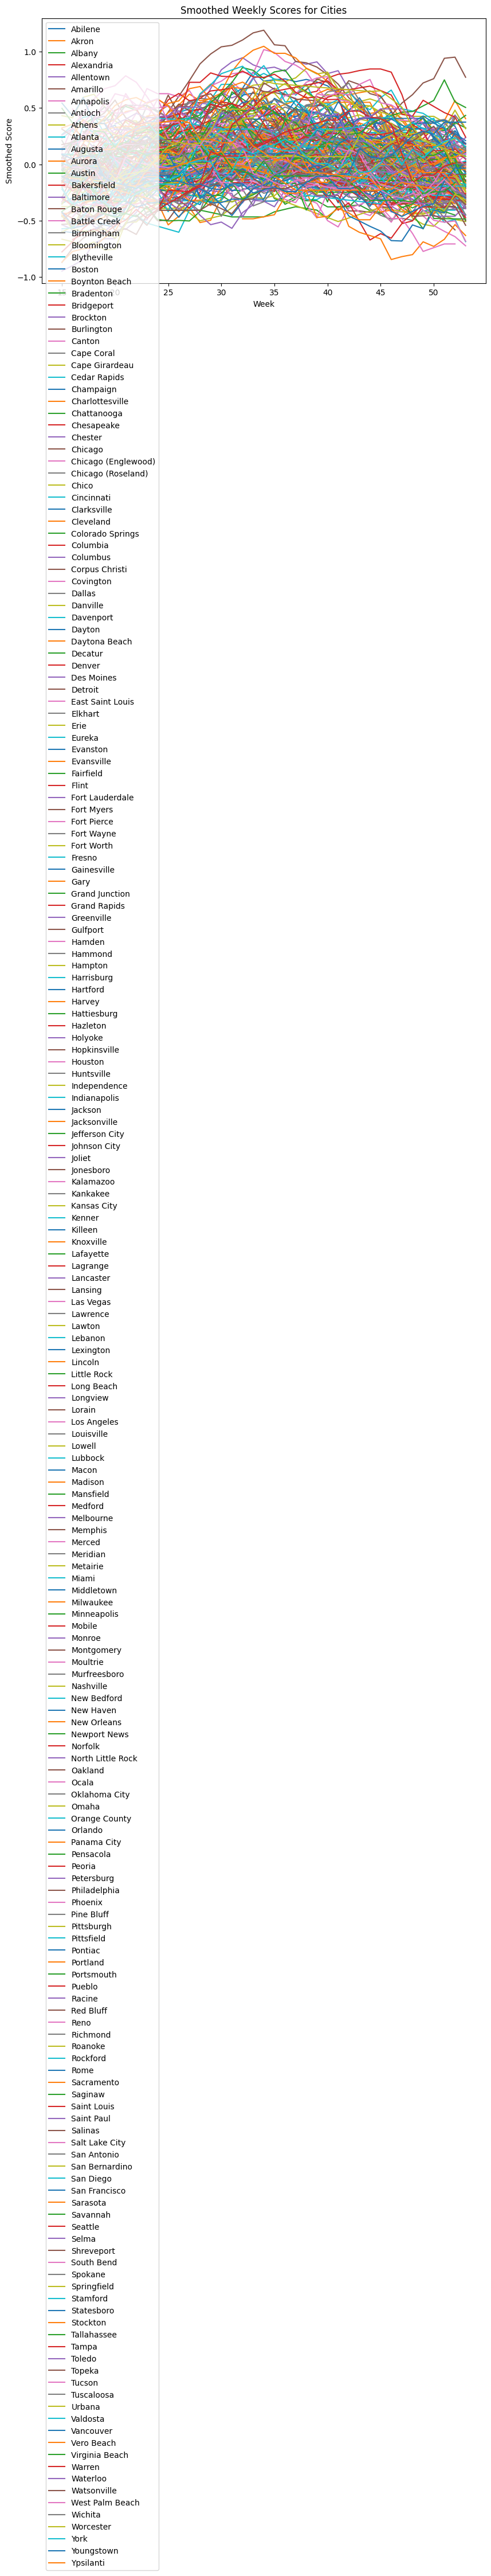

In [105]:
# Define the window size for the moving average
w = 15

# Plotting smoothed time series for each city
plt.figure(figsize=(10, 6))

for city in valid_cities['city_or_county'].unique():
    city_data = valid_cities[valid_cities['city_or_county'] == city]

    # Standardize the data
    standardized_scores = (city_data['weekly_score'] - city_data['weekly_score'].mean()) / city_data['weekly_score'].std()

    # Calculate the rolling mean
    smoothed_scores = standardized_scores.rolling(window=w).mean()

    # Plotting the smoothed scores
    plt.plot(city_data['week'], smoothed_scores, label=f'{city}')

plt.xlabel('Week')
plt.ylabel('Smoothed Score')
plt.title('Smoothed Weekly Scores for Cities')
plt.legend()
plt.show()

In [106]:
#  plot the autocorrelation plot
# from statsmodels.graphics.tsaplots import plot_acf

# # Plotting the autocorrelation plot for each city
# plt.figure(figsize=(10, 6))

# for city in valid_cities['city_or_county'].unique():
#     city_data = valid_cities[valid_cities['city_or_county'] == city]

#     # Standardize the data
#     standardized_scores = (city_data['weekly_score'] - city_data['weekly_score'].mean()) / city_data['weekly_score'].std()

#     # Plotting the autocorrelation plot
#     plot_acf(standardized_scores, lags=10, label=f'{city}')

# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.title('Autocorrelation Plot for Weekly Scores')
# plt.legend()
# plt.show()


## Computing Distances


In [107]:
from scipy.spatial.distance import euclidean


# Select two cities to compare
city1_data = valid_cities[valid_cities['city_or_county'] == 'Atlanta']['weekly_score']
city2_data = valid_cities[valid_cities['city_or_county'] == 'Dayton']['weekly_score']

# Make sure both series have the same length
min_length = min(len(city1_data), len(city2_data))
city1_data = city1_data[:min_length]
city2_data = city2_data[:min_length]

# Calculate Euclidean distance
distance = euclidean(city1_data, city2_data)
print(f"Euclidean Distance between Atlanta and Dayton: {distance}")

Euclidean Distance between Atlanta and Dayton: 26.846431844432843


In [108]:
from tslearn.metrics import dtw


# For tslearn, the time series need to be of the same length

city1_data = valid_cities[valid_cities['city_or_county'] == 'Atlanta']['weekly_score'].to_numpy()
city2_data = valid_cities[valid_cities['city_or_county'] == 'Dayton']['weekly_score'].to_numpy()

# Reshape data for tslearn
city1_data = city1_data.reshape(-1, 1)
city2_data = city2_data.reshape(-1, 1)

# Compute DTW distance
distance = dtw(city1_data, city2_data)
print(f"DTW Distance between Atlanta and Dayton: {distance}")

DTW Distance between Atlanta and Dayton: 17.297840263390622


# Clustering

## Shape Based Clustering

In [109]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [110]:
# Separate city names and numerical data
city_names = valid_cities['city_or_county'].unique()
numerical_data = [valid_cities[valid_cities['city_or_county'] == city]['weekly_score'].values for city in city_names]

In [111]:
# Ensure all series are of the same length (this is a simple example; you might need to pad or truncate)
max_length = max(len(series) for series in numerical_data)
padded_data = [np.pad(series, (0, max_length - len(series)), 'constant', constant_values=np.nan) for series in numerical_data]

In [112]:
# Convert to DataFrame for easy handling
padded_df = pd.DataFrame(padded_data)

In [113]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(padded_df)

In [114]:
# Reshape for TimeSeriesKMeans (n_series, series_length, n_features)
scaled_data = scaled_data.reshape((len(city_names), max_length, 1))

In [115]:
# Define and fit the model
n_clusters = 5 # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
labels = model.fit_predict(scaled_data)

In [116]:
# Map cluster labels back to city names
clustered_cities = pd.DataFrame({'City': city_names, 'Cluster': labels})


In [117]:
#Print the clustered cities
print(clustered_cities)


           City  Cluster
0       Abilene        3
1         Akron        3
2        Albany        3
3    Alexandria        3
4     Allentown        3
..          ...      ...
207     Wichita        0
208   Worcester        3
209        York        3
210  Youngstown        3
211   Ypsilanti        3

[212 rows x 2 columns]


In [118]:
#Print the labels
print(labels)

[3 3 3 3 3 3 3 3 3 0 3 3 3 0 4 0 3 0 3 3 0 3 3 0 3 3 3 3 3 3 3 3 0 3 3 1 0
 3 3 0 3 2 0 3 2 3 3 0 3 3 0 3 3 0 3 2 3 3 3 3 3 3 3 0 3 3 3 0 0 0 3 0 3 3
 3 3 3 3 3 3 0 3 3 3 3 3 2 3 3 2 0 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 0 3 3 3 3
 3 0 3 3 3 0 2 3 3 0 3 3 3 3 2 3 3 3 3 3 4 0 0 3 0 3 3 0 3 0 4 0 0 3 2 3 0
 0 3 0 3 3 3 3 4 0 3 0 3 3 3 3 3 3 3 3 0 3 3 3 0 3 4 3 0 3 0 3 3 0 3 0 0 3
 3 3 3 0 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 3 3]


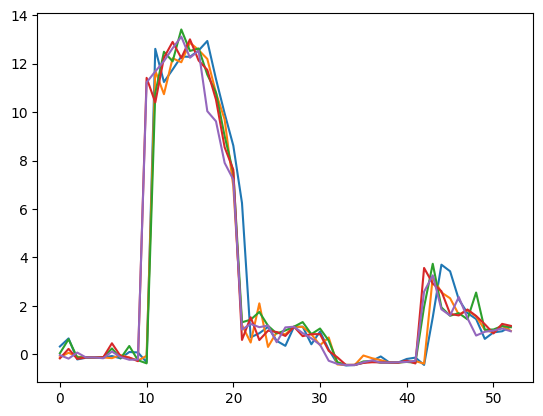

In [119]:
#Plot the cluster centers to see if there are differences among different centroids
plt.plot(model.cluster_centers_.reshape(scaled_data.shape[1], 5))
plt.show()

In [120]:
model.inertia_

1.2010005514027515

## Motifs and Anomalies


In [121]:
# Choose the city
city_name = "Atlanta"

In [122]:
# Extract the time series data for this city
city_data = valid_cities[valid_cities['city_or_county'] == city_name]

In [126]:
print(city_data.head())

     city_or_county  week  weekly_score
1101        Atlanta     1          7.25
1102        Atlanta     2          7.25
1103        Atlanta     3          3.25
1104        Atlanta     4          5.25
1105        Atlanta     5          5.75


In [125]:
# Sort by week, if not already sorted
city_data = city_data.sort_values(by='week')

In [127]:
# Extract the scores as a list or a NumPy array
time_series = city_data['weekly_score'].values

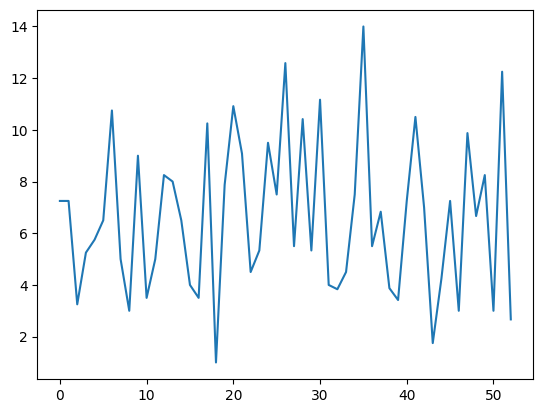

In [128]:
plt.plot(time_series)
plt.show()